Reserach for:
1) P000M015 Research Project 3 course at Kaunas university of technology, study programme - Applied Mathematics MSc.  
2) Research Council of Lithuania funded student research in their free time “Development and application of machine learning methods in assessing the risk of mortality of prostate cancer patients” (P-ST-22-28). (2022-2023).
  
Project github repo - https://github.com/vytautas9/Tiriamasis_Projektas_3
  
Author:  
Vytautas Kraujalis  
- LinkedIn - https://www.linkedin.com/in/vytautaskraujalis/  
- Email - vytautas.kraujalis2@gmail.com

### References

In [1]:
# Refernces
# https://www.mdpi.com/2072-6694/13/10/2453

# https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html -- paziuret sita
# https://andrewpwheeler.com/2020/09/26/discrete-time-survival-models-in-python/
# https://github.com/apwheele/Blog_Code/blob/master/Python/Discrete_Time/00_PrepData.py
# https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-022-01679-6 -- rimtas sitas


# pasiskaityt, gal i duomenis pridet "Restricted cubic splines function"
# https://towardsdatascience.com/restricted-cubic-splines-c0617b07b9a5
# https://github.com/apwheele/Blog_Code/tree/master/Python/Smooth
# https://andrewpwheeler.com/2020/09/20/making-smoothed-scatterplots-in-python/

### Modules

In [51]:
# Modules
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from tableone import TableOne # for the descriptive table
from matplotlib import pyplot as plt

### Functions
Functions, which will be used later in the project

In [37]:
def read_prepare_initial_data(path):
    # Read, prepare, anonimize the initial data
    df = pd.read_sas(path)
    
    # Select only relevant columns
    df = df[['Amzius', 'PSA', 'naujasCT', 'BxGleason', 'Bxkodas', 'RP_GG', 'pT', 
             'LNI01', 'R', 'PSAdaugiau0_1', 'BCR', 'MTS', 'SURVIVAL', 'OS', 'CSS',
             'DAmico', 'Rpgleson', 'TRYSgrupes', 'PLNDO1']]
    
    # Create survival column in years
    #df["survival_years"] = df["SURVIVAL"] / 12
    
    # Rename the column names
    df.rename(columns = {'Amzius': 'age', 'PSA': 'psa', 'naujasCT': 'clinical_stage', 
                         'Bxkodas': 'biopsy_gleason_gg', 'RP_GG': 'pathological_gleason_gg',
                         'pT': 'pathologic_stage', 'LNI01': 'lni', 'R': 'surgical_margin_status', 
                         'PSAdaugiau0_1': 'persistent_psa', 'SURVIVAL': 'survival_months', 
                         'BCR': 'bcr', 'MTS': 'mts', 'OS': 'overall_mortality', 
                         'CSS': 'cancer_specific_mortality'}, 
               inplace = True)
    
    # Fill the LNI column NA values with 'unknown' value
    df.fillna({'lni': 'unknown', 'r': 'unknown'}, inplace = True)
    
    # Drop rows with NA values, every row must have 0 NA values
    df.dropna(thresh=df.shape[1], inplace = True)
    
    # Change the data types of columns
    # Float --> Int --> String
    df[['overall_mortality']] = df[['overall_mortality']].astype(int)
    df[['cancer_specific_mortality']] = df[['cancer_specific_mortality']].astype(int)
    df[['mts']] = df[['mts']].astype(int)
    df[['bcr']] = df[['bcr']].astype(int)
    df[['clinical_stage']] = df[['clinical_stage']].astype(int)
    df[['biopsy_gleason_gg']] = df[['biopsy_gleason_gg']].astype(int)
    df[['pathological_gleason_gg']] = df[['pathological_gleason_gg']].astype(int)
    df[['pathologic_stage']] = df[['pathologic_stage']].astype(int)
    df[['surgical_margin_status']] = df[['surgical_margin_status']].astype(int)
    df[['persistent_psa']] = df[['persistent_psa']].astype(int)
    df[['DAmico']] = df[['DAmico']].astype(int)
    df[['TRYSgrupes']] = df[['TRYSgrupes']].astype(int)
    df[['PLNDO1']] = df[['PLNDO1']].astype(int)
    
    df = df.astype({'clinical_stage': 'str', 'biopsy_gleason_gg': 'str', 
                    'pathological_gleason_gg': 'str', 'pathologic_stage': 'str',
                    'lni': 'str', 'surgical_margin_status': 'str', 
                    'persistent_psa': 'str', 'bcr': 'str', 'mts': 'str', 
                    'overall_mortality': 'str', 'cancer_specific_mortality': 'str', 
                    'DAmico': 'str', 'TRYSgrupes': 'str', 'PLNDO1': 'str',
                    'survival_months': 'int32'})
    
    # Create death from other causes column
    df['death_from_other_causes'] = '0'
    df.loc[(df['overall_mortality'] == '1') & (df['cancer_specific_mortality'] == '0'), 'death_from_other_causes'] = '1'
    
    # Create a patient ID index
    df['patient_id'] = range(1, len(df) + 1)
    
    return df


# Explodes the provided data based on survival column
def explode_data(df,max_time,min_time=1,time='survival_months',
                 time_discrete='survival_time_discrete',cum_event=False):
    # We create a new time column and clip the data by provided min and max survival times
    df[time_discrete] = df[time].clip(min_time,max_time).apply(range)

    # Exploding the dataset with the created range value in new time column
    data_exploded = df.explode(time_discrete)

    # Reset index
    data_exploded.reset_index(drop=True, inplace=True)

    # New column starts at 0, we'll increase each value by 1
    data_exploded[time_discrete] = pd.to_numeric(data_exploded[time_discrete]) + 1

    # New event column, which will indicate the last event date
    data_exploded['cancer_specific_mortality_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['cancer_specific_mortality'])
    data_exploded['death_from_other_causes_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['death_from_other_causes'])
    data_exploded['mts_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['mts'])
    data_exploded['bcr_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['bcr'])
    
    if cum_event == True:
        # Create new event column with duplicated event values from discrete column
        data_exploded['cancer_specific_mortality_cumulative'] = data_exploded['cancer_specific_mortality_discrete']
        data_exploded['death_from_other_causes_cumulative'] = data_exploded['death_from_other_causes_discrete']
        data_exploded['mts_cumulative'] = data_exploded['mts_discrete']
        data_exploded['bcr_cumulative'] = data_exploded['bcr_discrete']
        
        after_survival_time = data_exploded[time_discrete] > data_exploded[time]
        
        # For cumulative events, after end_time we will have NA values, we'll replace those with event indicator
        discrete_column = ['cancer_specific_mortality_discrete', 'death_from_other_causes_discrete', 'mts_discrete', 'bcr_discrete']
        cumulative_column = ['cancer_specific_mortality_cumulative', 'death_from_other_causes_cumulative', 'mts_cumulative', 'bcr_cumulative']
        data_exploded.loc[after_survival_time, discrete_column] = -1
        data_exploded[discrete_column] = data_exploded[discrete_column].replace(-1,np.NaN)
        data_exploded.loc[(after_survival_time & (data_exploded['cancer_specific_mortality']==0)), 'cancer_specific_mortality_cumulative'] = -1
        data_exploded.loc[(after_survival_time & (data_exploded['death_from_other_causes']==0)), 'death_from_other_causes_cumulative'] = -1
        data_exploded.loc[(after_survival_time & (data_exploded['mts']==0)), 'mts_cumulative'] = -1
        data_exploded.loc[(after_survival_time & (data_exploded['bcr']==0)), 'bcr_cumulative'] = -1
        data_exploded[cumulative_column] = data_exploded[cumulative_column].replace(-1,np.NaN)
    return data_exploded


# Create dummy variables, split the data into train and test
def split_and_prepare_data(df, x_columns_to_drop, y_columns):
    
    # Create dummy variables for categorical data
    df = pd.get_dummies(df, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                    'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                    'DAmico', 'TRYSgrupes', 'PLNDO1'])
    df_train, df_test, y_train, y_test = train_test_split(
        df.drop(x_columns_to_drop, axis=1),
        df[y_columns], test_size=0.20, random_state=1, stratify=df[['overall_mortality']])
    
    df_train[y_columns] = y_train
    df_test[y_columns] = y_test
    
    return df_train, df_test


# Cumulative hazard based on predicted probabilities, for instant time points.
# Can be grouped by patients
def cumulative_hazard(df, event_probability_column, id_column):
    data_copy = df.copy()
    if id_column is not None:
        data_copy = data_copy[ [id_column, event_probability_column] ]
    else:
        data_copy = data_copy[ [event_probability_column] ]
    data_copy['negative_log_prob'] = np.log( 1 - data_copy[event_probability_column] )
    if id_column is not None:
        data_copy['cumulative_hazard'] = 1 - np.exp(data_copy.groupby(id_column)['negative_log_prob'].transform(pd.Series.cumsum))
    else:
        data_copy['cumulative_hazard'] = 1 - np.exp(data_copy['negative_log_prob'].cumsum())
    return data_copy['cumulative_hazard']


# Train the model based on training data.
# Before training, explode the data with given maximum time and save the model
def train_model(model, df_train, target_column, max_time, min_time=1, x_columns_to_drop=None):
    df_train_copy = df_train.copy()
    
    # Extract model name
    model_name = type(model).__name__
    print(f'Experiment with {model_name}:')
    print(f'\tStarting fitting a {model_name} model...')
    
    # Explode the dataset
    df_train_copy_exploded = explode_data(df_train_copy, max_time=max_time)
    
    # Drop columns/targets from feature set
    if x_columns_to_drop is not None:
        X_train = df_train_copy_exploded.drop(x_columns_to_drop, axis=1)
    else:    
        X_train = df_train_copy_exploded.drop(target_column, axis=1)
        
    y_train = df_train_copy_exploded[target_column]
    
    # Fit model to training data
    model.fit(X_train, y_train)
    print(f'\tFinished fitting.')

    # Save model
    model_path = f'results/{target_column}/{max_time}/{model_name}'
    print(f'\tSaving results to "{model_path}"...')
    # Create directory if does not exist
    Path(model_path).mkdir(parents=True, exist_ok=True)
    
    with open(f'{model_path}/model.sav', 'wb') as f:
        pickle.dump(model, f)
    print(f'\tFinished saving reults.')
    
    return model


# Given non exploded dataset, explode the dataset based on maximum time
# and add predicted instant mortality probabilities and also cumulative.
# Returns exploded dataset with probabilities
def add_predict_probabilities(df, model, max_time, target_column):
    df_exploded = explode_data(df, max_time=max_time, min_time=max_time, cum_event=True)

    # List of columns names which will be dropped from feature set before predicting outcome
    x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                         'death_from_other_causes', 'cancer_specific_mortality',
                         'death_from_other_causes_discrete', 'mts_discrete',
                         'bcr_discrete', 'cancer_specific_mortality_discrete',
                         'cancer_specific_mortality_cumulative',
                         'death_from_other_causes_cumulative', 'mts_cumulative',
                         'bcr_cumulative']

    X_df = df_exploded.drop(x_columns_to_drop, axis=1)
    #y_df = df_exploded[target_column]

    # probabilities
    y_pred = model.predict_proba(X_df)[:,1]
    df_exploded['mortality_instant_prob'] = y_pred

    # Cumulative hazard for each patient
    df_exploded['cumulative_hazard'] = cumulative_hazard(df_exploded,'mortality_instant_prob','patient_id')
    
    return df_exploded


# Given exploded dataset, id of a patient and a target column plots cumulative and
# instant mortality plots of the given patient
def plot_single_patient(df, patient_id, target_column, target_title='Mortality', fix_axis=True):
    if patient_id not in df['patient_id'].values:
        print(f'Patient {patient_id} is not in the dataset.')
        return
    
    # Subset of data for the given patient
    person = df[df['patient_id'] == patient_id]
    
    # Get the column indexes of required columns
    mortality_column_index = person.columns.get_loc(target_column)
    survival_column_index = person.columns.get_loc('survival_months')
    max_time_value = person.survival_time_discrete.max()
    
    # Extract model name
    model_name = type(model).__name__
    model_path = f'results/{target_column + "_discrete"}/{max_time_value}/{model_name}'
    
    # Plot cumulative mortality of the given patient
    fig, ax = plt.subplots()
    ax.plot(person['survival_time_discrete'],person['cumulative_hazard'],
            alpha=0.6,color='k',drawstyle='steps-post')
    # Add line when the patient actually died
    if person.iloc[0,mortality_column_index] == '1' and person.iloc[0,survival_column_index] < max_time_value:
        ax.axvline(person.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                   color='red',linewidth=2, zorder=1)
    ax.set_xlabel('Months')
    ax.set_ylabel('Cumulative Probability of ' + target_title)
    if fix_axis:
        ax.set_ylim([0, 1])
    plt.title(f'Patient {person.patient_id.iloc[0]:.0f}')
    plt.savefig(f'{model_path}/cumulative_person_{person.patient_id.iloc[0]}.png', dpi=500, bbox_inches='tight')
    plt.show()

    # Plot instant mortality of the given patient
    fig, ax = plt.subplots()
    ax.plot(person['survival_time_discrete'],person['mortality_instant_prob'],
            alpha=0.6,color='k')
    ax.set_xlabel('Months')
    ax.set_ylabel('Instant Probability of ' + target_title)
    if fix_axis:
        ax.set_ylim([0, 1])
    plt.title(f'Patient {person.patient_id.iloc[0]:.0f}')
    plt.savefig(f'{model_path}/instant_person_{person.patient_id.iloc[0]}.png', dpi=500, bbox_inches='tight')
    plt.show()


# TODO
def run_experiment(df_train, df_test, model, max_time, target_column):
    # List of columns names which will be dropped from feature set before fitting the model
    x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                         'death_from_other_causes', 'cancer_specific_mortality',
                         'death_from_other_causes_discrete', 'mts_discrete',
                         'bcr_discrete', 'cancer_specific_mortality_discrete']
    
    model = train_model(model=model, df_train=df_train, target_column=target_column+'_discrete',
                   max_time=max_time, x_columns_to_drop=x_columns_to_drop)
    
    # Test on training data
    df_train_predicted = add_predict_probabilities(df_train, model=model, max_time=max_time, 
                                                     target_column=target_column)
    
    # Test on testing data
    df_test_predicted = add_predict_probabilities(df_test, model=model, max_time=max_time, 
                                                    target_column=target_column)
    
    # AUC for each cumulative slice
    # Months at which we'll check the AUC's
    months = list(range(6, max_time, 6))

    train_auc_stats = []
    test_auc_stats = []
    for month in months:
        # --- Training data ---
        # Selecting a subset of data based on the months
        select = (df_train_predicted['survival_time_discrete'] == month) & pd.notna(df_train_predicted[target_column+'_cumulative'])
        sub_dat = df_train_predicted[select]

        # If in the sliced data there's a event, calculate AUC metric,
        # otherwise assign NaN value
        if sub_dat[target_column+'_cumulative'].max() == 1:
            fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
            auc_stat = auc(fpr, tpr)
        else:
            auc_stat = float('NaN')
        train_auc_stats.append(auc_stat)

        # --- Testing data ---
        # Selecting a subset of data based on the months
        select = (df_test_predicted['survival_time_discrete'] == month) & pd.notna(df_test_predicted[target_column+'_cumulative'])
        sub_dat = df_test_predicted[select]

        # If in the sliced data there's a event, calculate AUC metric,
        # otherwise assign NaN value
        if sub_dat[target_column+'_cumulative'].max() == 1:
            fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
            auc_stat = auc(fpr, tpr)
        else:
            auc_stat = float('NaN')
        test_auc_stats.append(auc_stat)

    auc_stats = pd.DataFrame(zip(months, train_auc_stats, test_auc_stats),
                             columns=['month', 'train_auc', 'test_auc'])
    
    # Save the auc statistics
    model_name = type(model).__name__
    with open(f'results/{target_column+"_discrete"}/{max_time}/{model_name}/auc_statistics.pkl', 'wb') as f:
        pickle.dump(auc_stats, f)
    
    
def read_experiment(model_name, target_column, max_time):
    model_path = f'results/{target_column+"_discrete"}/{max_time}/{model_name}'
        
    # Read model
    with open(f'{model_path}/model.sav', 'rb') as f:
        model = pickle.load(f)
    
    # Read auc statistic
    with open(f'{model_path}/auc_statistics.pkl', 'rb') as f:
        auc_stats = pickle.load(f)
    return model, auc_stats

## Main program

In [3]:
# Read the original data
data_path = 'Data/persistentpsa_3.sas7bdat'
data = read_prepare_initial_data(data_path)
with open('Data/project_3_data_prepared.pkl', 'wb') as f:
    pickle.dump(data, f)

# Read already prepared and saved data
#with open('Data/project_3_data_prepared.pkl', 'rb') as f:
#    data = pickle.load(f)

In [4]:
# Explore the original data
print('Original data shape: ', data.shape)
print('\nSample data:\n', data.head(), '\n')
print(data.describe(), '\n')

# Descriptive statistics
min_max = ['age']
nonnormal = ['age', 'psa', 'BxGleason', 'survival_months']

# -------------------------
# Overall mortality
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'mts', 'cancer_specific_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'overall_mortality'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------
# Cancer Specific Mortality
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'mts', 'overall_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'cancer_specific_mortality'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------
# Death from other causes
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'mts', 'cancer_specific_mortality', 'overall_mortality']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'death_from_other_causes'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------
# BCR
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'overall_mortality', 'mts', 'cancer_specific_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'bcr'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------
# MTS
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'overall_mortality', 'cancer_specific_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'mts'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False)
print(mytable.tabulate(tablefmt="github"), '\n')
# -------------------------


Original data shape:  (1565, 21)

Sample data:
     age    psa clinical_stage  BxGleason biopsy_gleason_gg  \
0  72.0  12.70              2        7.0                 2   
1  66.0   7.59              3        9.0                 5   
2  65.0   7.60              3        7.0                 2   
3  70.0  14.18              3        7.0                 3   
4  57.0   7.86              2        7.0                 3   

  pathological_gleason_gg pathologic_stage  lni surgical_margin_status  \
0                       2                2  1.0                      1   
1                       5                1  1.0                      1   
2                       2                2  1.0                      0   
3                       3                2  1.0                      1   
4                       4                1  1.0                      0   

  persistent_psa  ... mts survival_months  overall_mortality  \
0              0  ...   0             138                  0   
1     

|                                 |         | Overall            | 0                  | 1                 |
|---------------------------------|---------|--------------------|--------------------|-------------------|
| n                               |         | 1565               | 1351               | 214               |
| Age (years), median [min,max]   |         | 64.0 [40.0,87.0]   | 63.0 [40.0,87.0]   | 68.0 [53.0,78.0]  |
| psa, median [Q1,Q3]             |         | 6.5 [4.8,9.7]      | 6.3 [4.8,9.5]      | 7.2 [5.2,10.5]    |
| clinical_stage, n (%)           | 1       | 435 (27.8)         | 381 (28.2)         | 54 (25.2)         |
|                                 | 2       | 911 (58.2)         | 783 (58.0)         | 128 (59.8)        |
|                                 | 3       | 219 (14.0)         | 187 (13.8)         | 32 (15.0)         |
| BxGleason, median [Q1,Q3]       |         | 6.0 [6.0,7.0]      | 6.0 [6.0,7.0]      | 6.0 [6.0,7.0]     |
| biopsy_gleason_gg, n (%)  

|                                 |         | Overall            | 0                  | 1                 |
|---------------------------------|---------|--------------------|--------------------|-------------------|
| n                               |         | 1565               | 1466               | 99                |
| Age (years), median [min,max]   |         | 64.0 [40.0,87.0]   | 64.0 [40.0,87.0]   | 65.0 [48.0,73.0]  |
| psa, median [Q1,Q3]             |         | 6.5 [4.8,9.7]      | 6.3 [4.8,9.5]      | 8.8 [6.5,14.3]    |
| clinical_stage, n (%)           | 1       | 435 (27.8)         | 427 (29.1)         | 8 (8.1)           |
|                                 | 2       | 911 (58.2)         | 852 (58.1)         | 59 (59.6)         |
|                                 | 3       | 219 (14.0)         | 187 (12.8)         | 32 (32.3)         |
| BxGleason, median [Q1,Q3]       |         | 6.0 [6.0,7.0]      | 6.0 [6.0,7.0]      | 7.0 [6.0,8.0]     |
| biopsy_gleason_gg, n (%)  

In [5]:
# Train - test split
x_columns_to_drop = ['bcr', 'mts', 'overall_mortality', 'cancer_specific_mortality', 
                     'death_from_other_causes']
y_columns = ['bcr', 'mts', 'death_from_other_causes', 'cancer_specific_mortality']
data_train, data_test = split_and_prepare_data(data, x_columns_to_drop=x_columns_to_drop,
                                               y_columns=y_columns)

In [6]:
print('Shape of train: ', data_train.shape, '\n')
print('Shape of test: ', data_test.shape, '\n')

Shape of train:  (1252, 42) 

Shape of test:  (313, 42) 



In [7]:
# Check min and max survival times
print(f'Max training survival months - {data_train["survival_months"].max()}')
print(f'Min training survival months - {data_train["survival_months"].min()}')

print('\nID of patients who experienced deaths')
print(data_train[data_train['cancer_specific_mortality'] == '1'].patient_id)

Max training survival months - 225
Min training survival months - 1

ID of patients who experienced deaths
329      312
541      520
182      173
164      155
38        35
619      594
702      672
1108    1052
21        22
15        16
259      247
33        31
1          2
1327    1257
185      176
18        19
736      704
600      578
31        30
37        34
907      856
25        25
16        17
1332    1262
698      669
235      223
202      193
948      897
537      516
191      182
28        28
1489    1413
186      177
649      623
188      179
641      615
650      624
896      845
19        20
117      111
255      243
410      393
Name: patient_id, dtype: int64


In [8]:
# Logistic Regression
# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)

# Run the experiment
run_experiment(df_train=data_train, df_test=data_test, model=model, 
               max_time=100, target_column='cancer_specific_mortality')

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/100/LogisticRegression"...


In [47]:
# Read the experiment
model, auc_stats = read_experiment('LogisticRegression', 'cancer_specific_mortality', 100)

data_train_predicted = add_predict_probabilities(data_train, model=model, max_time=max_time, 
                                                 target_column=target_column)

plot_single_patient(data_train_predicted, patient_id=23, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality', fix_axis=True)

Patient 23 is not in the dataset.


In [43]:
trainable_months = list(range(24, 225, 12))

for target_column in ['cancer_specific_mortality', 'death_from_other_causes', 'mts', 'bcr']:
    for month in trainable_months:
        # Define the logistic regression model
        model = LogisticRegression(solver='liblinear', random_state=0)
        # Run the experiment
        run_experiment(df_train=data_train, df_test=data_test, model=model, 
                       max_time=month, target_column=target_column)
        
        # Define the logistic regression model
        model = RandomForestClassifier(n_estimators=500, random_state=0, criterion='entropy', max_depth=3)
        # Run the experiment
        run_experiment(df_train=data_train, df_test=data_test, model=model, 
                       max_time=month, target_column=target_column)

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/24/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/24/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/36/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/36/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Savi

Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/death_from_other_causes_discrete/36/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/death_from_other_causes_discrete/48/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/death_from_other_causes_discrete/48/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/death_from_other_causes_discrete/60/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Savi

Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/mts_discrete/60/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/mts_discrete/72/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/mts_discrete/72/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/mts_discrete/84/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/mts_discrete/84/RandomForestClassifier"...
	Finished savi

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/bcr_discrete/108/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/bcr_discrete/108/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/bcr_discrete/120/LogisticRegression"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/bcr_discrete/120/RandomForestClassifier"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/bcr_discrete/132/LogisticRegression"...
	Finished saving reul

In [10]:
result_files = glob('results' + '/**/auc_statistics.pkl', recursive = True)

auc_stats_all = pd.DataFrame()
for file in result_files:
    directory_names = file.split('\\')
    target_column = directory_names[1].removesuffix('_discrete')
    max_time = directory_names[2]
    model_name = directory_names[3]

    with open(file, 'rb') as f:
        auc_stats = pickle.load(f)

    auc_stats['target_column'] = target_column
    auc_stats['max_time'] = max_time
    auc_stats['model_name'] = model_name
    
    auc_stats_all = pd.concat([auc_stats_all, auc_stats], ignore_index=True)

In [40]:
# Random Forest
# Check for hyperparameter optimization:
# https://towardsdatascience.com/mastering-random-forests-a-comprehensive-guide-51307c129cb1#:~:text=Generally%2C%20we%20go%20with%20a,vary%20between%20each%20decision%20tree.
# ------------------------------
# Interesting fact, as we add more trees and change the max_depth and entropy, the most important feature
# changes significantly. With default parameters, only survival_time_discrete is important.
# With optimized parameters survival_time_discrete is not that important.
# ------------------------------
# Define the model
model = RandomForestClassifier(n_estimators=500, random_state=0, criterion='entropy', max_depth=3)

# Run the experiment
run_experiment(df_train=data_train, df_test=data_test, model=model, 
               max_time=100, target_column='cancer_specific_mortality')

model, auc_stats = read_experiment('RandomForestClassifier', 'cancer_specific_mortality', 100)

print(auc_stats)

Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/100/RandomForestClassifier"...
	Finished saving reults.


In [55]:
# XGBoost
# Define the model
model = XGBClassifier(objective="binary:logistic", random_state=0, n_estimators=500, max_depth=3)

# Run the experiment
run_experiment(df_train=data_train, df_test=data_test, model=model, 
               max_time=100, target_column='cancer_specific_mortality')

model, auc_stats = read_experiment('XGBClassifier', 'cancer_specific_mortality', 100)

print(auc_stats)

Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/100/XGBClassifier"...
	Finished saving reults.
    month  train_auc  test_auc
0       6        NaN       NaN
1      12        NaN       NaN
2      18   1.000000       NaN
3      24   1.000000       NaN
4      30   1.000000  0.538462
5      36   1.000000  0.583333
6      42   1.000000  0.541667
7      48   1.000000  0.575321
8      54   1.000000  0.572115
9      60   1.000000  0.847312
10     66   0.999798  0.813441
11     72   0.999667  0.792473
12     78   0.998585  0.797312
13     84   0.998557  0.684871
14     90   0.998216  0.715210
15     96   0.997519  0.724026


In [60]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

xgb_model = XGBClassifier()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

# Explode the dataset
df_train_copy_exploded = explode_data(data_train, max_time=100)

# List of columns names which will be dropped from feature set before fitting the model
x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                     'death_from_other_causes', 'cancer_specific_mortality',
                     'death_from_other_causes_discrete', 'mts_discrete',
                     'bcr_discrete', 'cancer_specific_mortality_discrete']

# Drop columns/targets from feature set
if x_columns_to_drop is not None:
    X_train = df_train_copy_exploded.drop(x_columns_to_drop, axis=1)
else:    
    X_train = df_train_copy_exploded.drop('cancer_specific_mortality_discrete', axis=1)

y_train = df_train_copy_exploded['cancer_specific_mortality_discrete']




search.fit(X_train, y_train)



Fitting 3 folds for each of 200 candidates, totalling 600 fits


NameError: name 'report_best_scores' is not defined

In [62]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report_best_scores(search.cv_results_, 1)

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'colsample_bytree': 0.8123620356542087, 'gamma': 0.4753571532049581, 'learning_rate': 0.24959818254342153, 'max_depth': 2, 'n_estimators': 120, 'subsample': 0.6624074561769746}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'colsample_bytree': 0.7061753482887407, 'gamma': 0.48495492608099716, 'learning_rate': 0.2797327922401265, 'max_depth': 3, 'n_estimators': 101, 'subsample': 0.6727299868828402}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'colsample_bytree': 0.8835558684167137, 'gamma': 0.06974693032602092, 'learning_rate': 0.11764339456056544, 'max_depth': 5, 'n_estimators': 114, 'subsample': 0.7824279936868144}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'colsample_bytree': 0.935552788417904, 'gamma': 0.09983689107917987, 'learning_rate': 0.18427033152408348, 'max_depth': 5, 'n_estimators': 102, 'subsample': 0.9439761626

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/100/LogisticRegression"...


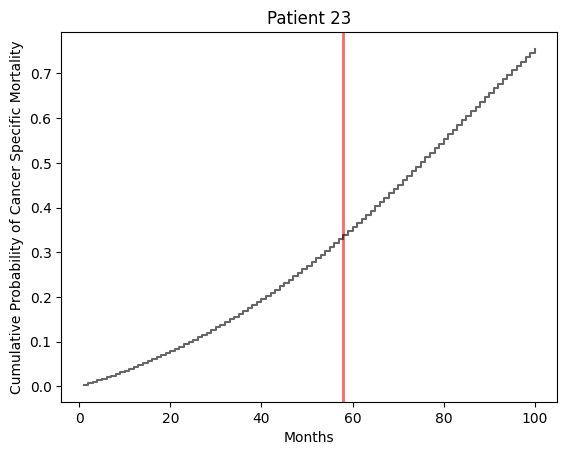

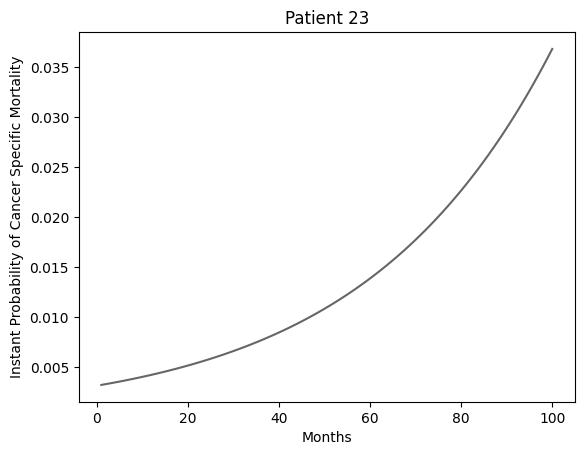

    month  train_auc  test_auc
0       6        NaN       NaN
1      12        NaN       NaN
2      18   0.991207       NaN
3      24   0.986923       NaN
4      30   0.974719  0.721154
5      36   0.978887  0.721154
6      42   0.979708  0.721154
7      48   0.979015  0.721154
8      54   0.979015  0.721154
9      60   0.972883  0.906452
10     66   0.957625  0.906452
11     72   0.934889  0.906452
12     78   0.928574  0.906452
13     84   0.928222  0.890777
14     90   0.931156  0.890777
15     96   0.930527  0.874026


In [13]:
# ONE EXPERIMENT
# At which time we'll clip out the data
max_time = 100
target_column = 'cancer_specific_mortality'
target_title = 'Cancer Specific Mortality'


# List of columns names which will be dropped from feature set before fitting the model
x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                     'death_from_other_causes', 'cancer_specific_mortality',
                     'death_from_other_causes_discrete', 'mts_discrete',
                     'bcr_discrete', 'cancer_specific_mortality_discrete']

# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)
model = train_model(model=model, df_train=data_train, target_column=target_column+'_discrete',
                   max_time=max_time, x_columns_to_drop=x_columns_to_drop)

# Test on training data
data_train_predicted = add_predict_probabilities(data_train, model=model, max_time=max_time, 
                                                 target_column=target_column)

# Test on testing data
data_test_predicted = add_predict_probabilities(data_test, model=model, max_time=max_time, 
                                                target_column=target_column)

plot_single_patient(data_test_predicted, patient_id=23, 
                    target_column=target_column, 
                    target_title=target_title, fix_axis=False)

# Discrimination Metrics
# AUC for each cumulative slice

# Months at which we'll check the AUC's
check_months = list(range(6, max_time, 6))

train_auc_stats = []
test_auc_stats = []
for w in check_months:
    # --- Training data ---
    # Selecting a subset of data based on the months
    select = (data_train_predicted['survival_time_discrete'] == w) & pd.notna(data_train_predicted[target_column+'_cumulative'])
    sub_dat = data_train_predicted[select]
    
    # If in the sliced data there's a event, calculate AUC metric,
    # otherwise assign NaN value
    if sub_dat[target_column+'_cumulative'].max() == 1:
        fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
        auc_stat = auc(fpr, tpr)
    else:
        auc_stat = float('NaN')
    train_auc_stats.append(auc_stat)
    
    # --- Testing data ---
    # Selecting a subset of data based on the months
    select = (data_test_predicted['survival_time_discrete'] == w) & pd.notna(data_test_predicted[target_column+'_cumulative'])
    sub_dat = data_test_predicted[select]
    
    # If in the sliced data there's a event, calculate AUC metric,
    # otherwise assign NaN value
    if sub_dat[target_column+'_cumulative'].max() == 1:
        fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
        auc_stat = auc(fpr, tpr)
    else:
        auc_stat = float('NaN')
    test_auc_stats.append(auc_stat)
    
auc_stats = pd.DataFrame(zip(check_months, train_auc_stats, test_auc_stats),
                         columns=['month', 'train_auc', 'test_auc'])
print(auc_stats)   


In [216]:
w = 100

select = (data_test_exploded['survival_time_discrete'] == w) & pd.notna(data_test_exploded['cancer_specific_mortality_cumulative'])
sub_dat = data_test_exploded[select]
fpr, tpr, thresholds = metrics.roc_curve(sub_dat['cancer_specific_mortality_cumulative'], sub_dat['CumHazard'])
auc_stat = metrics.auc(fpr, tpr)
print(f'fpr: {fpr} \n tpr: {tpr} \n thresholds: {thresholds} \n auc: {auc_stat} \n') 


fpr: [0.         0.00324675 0.00324675 0.15909091 0.15909091 0.19480519
 0.19480519 0.26948052 0.26948052 1.        ] 
 tpr: [0.  0.  0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ] 
 thresholds: [1.87187606e+00 8.71876061e-01 7.54734109e-01 3.35485950e-02
 3.27204372e-02 2.50409363e-02 2.39744160e-02 1.80712101e-02
 1.79000137e-02 6.80889266e-04] 
 auc: 0.874025974025974 



In [221]:
print(sub_dat.shape)
print('\n',sub_dat.cancer_specific_mortality_cumulative.value_counts())
print('\n',sub_dat.cancer_specific_mortality.value_counts())
print('\n',sub_dat.cancer_specific_mortality_discrete.value_counts())
print('\n', data_test_exploded.cancer_specific_mortality_cumulative.value_counts())

(313, 53)

 0    308
1      5
Name: cancer_specific_mortality_cumulative, dtype: int64

 0    305
1      8
Name: cancer_specific_mortality, dtype: int64

 0.0    174
Name: cancer_specific_mortality_discrete, dtype: int64

 0    31119
1      181
Name: cancer_specific_mortality_cumulative, dtype: int64


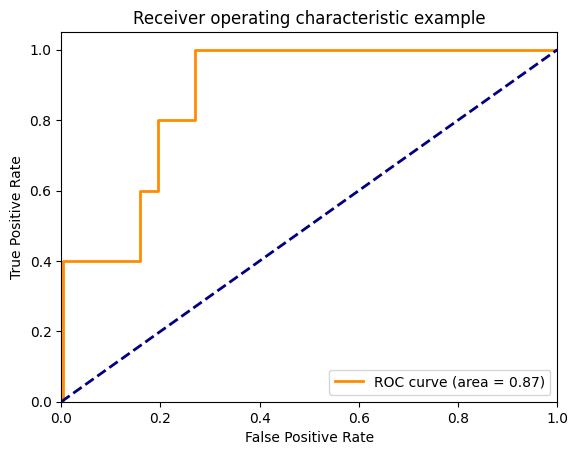

In [222]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = metrics.roc_curve(sub_dat['cancer_specific_mortality_cumulative'], sub_dat['CumHazard'])
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [223]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.0179000136664057


In [224]:
select = (data_test_exploded['survival_time_discrete'] == w) & pd.notna(data_test_exploded['cancer_specific_mortality_cumulative'])
sub_dat = data_test_exploded[select]
sub_X_test = sub_dat.drop(['survival_months', 'patient_id', 'bcr', 'mts',
                          'death_from_other_causes', 'cancer_specific_mortality',
                          'death_from_other_causes_discrete', 'mts_discrete',
                          'bcr_discrete', 'cancer_specific_mortality_discrete',
                             'cancer_specific_mortality_cumulative',
                             'death_from_other_causes_cumulative', 'mts_cumulative',
                             'bcr_cumulative', 'InstProb', 'CumHazard'], axis=1)
print(sub_X_test.columns)

Index(['age', 'psa', 'BxGleason', 'Rpgleson', 'clinical_stage_1',
       'clinical_stage_2', 'clinical_stage_3', 'biopsy_gleason_gg_1',
       'biopsy_gleason_gg_2', 'biopsy_gleason_gg_3', 'biopsy_gleason_gg_4',
       'biopsy_gleason_gg_5', 'pathological_gleason_gg_1',
       'pathological_gleason_gg_2', 'pathological_gleason_gg_3',
       'pathological_gleason_gg_4', 'pathological_gleason_gg_5',
       'pathologic_stage_0', 'pathologic_stage_1', 'pathologic_stage_2',
       'lni_0.0', 'lni_1.0', 'lni_unknown', 'surgical_margin_status_0',
       'surgical_margin_status_1', 'persistent_psa_0', 'persistent_psa_1',
       'DAmico_0', 'DAmico_1', 'DAmico_2', 'DAmico_3', 'TRYSgrupes_0',
       'TRYSgrupes_1', 'TRYSgrupes_2', 'PLNDO1_0', 'PLNDO1_1',
       'survival_time_discrete'],
      dtype='object')


In [234]:


temp_y_pred = (model.predict_proba(sub_X_test)[:,1] >= 0.018 ).astype(int)
#temp_y_pred = model.predict_proba(X_test)[:,1]

In [235]:
pd.Series(temp_y_pred).value_counts()

0    309
1      4
dtype: int64

In [236]:
print(confusion_matrix(sub_dat.cancer_specific_mortality_cumulative, temp_y_pred), '\n')
print(classification_report(sub_dat.cancer_specific_mortality_cumulative, temp_y_pred, zero_division=0), '\n')
print(roc_auc_score(sub_dat.cancer_specific_mortality_cumulative, model.predict_proba(sub_X_test)[:,1]))

[[306   2]
 [  3   2]] 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       308
           1       0.50      0.40      0.44         5

    accuracy                           0.98       313
   macro avg       0.75      0.70      0.72       313
weighted avg       0.98      0.98      0.98       313
 

0.874025974025974


In [25]:
# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)

# Run the experiment
run_experiment(X_train.drop(['survival_months', 'patient_id'], axis=1), 
               X_test.drop(['survival_months', 'patient_id'], axis=1), 
               y_train.cancer_specific_mortality_discrete, 
               y_test.cancer_specific_mortality_discrete, 
               model)

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/LogisticRegression"...
	Finished saving results.


In [28]:
# Example of reading experiment

model, experiment_info = read_experiment(model_name='LogisticRegression', 
                                         target_column='cancer_specific_mortality_discrete')

print(experiment_info)

{'model_name': 'LogisticRegression', 'confusion_matrix': {'train': array([[136965,      0],
       [    36,      0]], dtype=int64), 'test': array([[33142,     0],
       [   14,     0]], dtype=int64)}, 'classification_report': {'train': {'0': {'precision': 0.9997372281954147, 'recall': 1.0, 'f1-score': 0.9998685968331837, 'support': 136965}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 36}, 'accuracy': 0.9997372281954147, 'macro avg': {'precision': 0.49986861409770733, 'recall': 0.5, 'f1-score': 0.49993429841659187, 'support': 137001}, 'weighted avg': {'precision': 0.9994745254398507, 'recall': 0.9997372281954147, 'f1-score': 0.9996058595576456, 'support': 137001}}, 'test': {'0': {'precision': 0.9995777536494149, 'recall': 1.0, 'f1-score': 0.9997888322423, 'support': 33142}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14}, 'accuracy': 0.9995777536494149, 'macro avg': {'precision': 0.49978887682470746, 'recall': 0.5, 'f1-score': 0.49989441612